In [33]:
# Phoenix coordinates
lat, lon = 33.4484, -112.0740
start = "2023-01-01"
end = "2023-12-31"

In [39]:
STAC_API = "https://earth-search.aws.element84.com/v1"
COLLECTION = "sentinel-2-l2a"

catalog = pystac_client.Client.open(STAC_API)
search = catalog.search(
    collections=[COLLECTION],
    datetime=f"{start}/{end}",
    bbox=(lon - 0.01, lat - 0.01, lon + 0.01, lat + 0.01),  # Bounding box to cover a wider area
    max_items=100,
    query={"eo:cloud_cover": {"lt": 20}},  # Lower cloud cover to increase image clarity
)

all_items = search.get_all_items()

items = []
dates = []
for item in all_items:
    if item.datetime.date() not in dates:
        items.append(item)
        dates.append(item.datetime.date())

print(f"Found {len(all_items)} items for Phoenix, Arizona.")


/Users/hana/anaconda3/envs/claymodel/lib/python3.11/site-packages/pystac_client/item_search.py:851: FutureWarning: get_all_items() is deprecated, use item_collection() instead.
  warnings.warn(


Found 100 items for Phoenix, Arizona.


In [68]:
import stackstac
import xarray as xr
import matplotlib.pyplot as plt


stack = stackstac.stack(
    items,
    bounds=bounds,
    snap_bounds=False,
    epsg=epsg,
    resolution=gsd,
    dtype="float64",
    rescale=False,
    fill_value=0,
    assets=["blue", "green", "red", "nir"],
    resampling=Resampling.nearest,
)

stack = stack.compute()

print(stack)


<xarray.DataArray 'stackstac-23f093df4308828266f6ddad062deb9e' (time: 53,
                                                                band: 4,
                                                                y: 128, x: 128)> Size: 28MB
dask.array<fetch_raster_window, shape=(53, 4, 128, 128), dtype=float64, chunksize=(1, 1, 128, 128), chunktype=numpy.ndarray>
Coordinates: (12/53)
  * time                                     (time) datetime64[ns] 424B 2023-...
    id                                       (time) <U24 5kB 'S2A_12SUC_20230...
  * band                                     (band) <U5 80B 'blue' ... 'nir'
  * x                                        (x) float64 1kB 3.995e+05 ... 4....
  * y                                        (y) float64 1kB 3.702e+06 ... 3....
    constellation                            <U10 40B 'sentinel-2'
    ...                                       ...
    gsd                                      int64 8B 10
    title                               

In [69]:
print(stack.coords['band'])

<xarray.DataArray 'band' (band: 4)> Size: 80B
array(['blue', 'green', 'red', 'nir'], dtype='<U5')
Coordinates: (12/20)
  * band                                     (band) <U5 80B 'blue' ... 'nir'
    constellation                            <U10 40B 'sentinel-2'
    s2:saturated_defective_pixel_percentage  int64 8B 0
    mgrs:utm_zone                            int64 8B 12
    s2:datatake_type                         <U8 32B 'INS-NOBS'
    processing:software                      object 8B {'sentinel2-to-stac': ...
    ...                                       ...
    gsd                                      int64 8B 10
    title                                    (band) <U20 320B 'Blue (band 2) ...
    common_name                              (band) <U5 80B 'blue' ... 'nir'
    center_wavelength                        (band) float64 32B 0.49 ... 0.842
    full_width_half_max                      (band) float64 32B 0.098 ... 0.145
    epsg                                     int64 8B 3

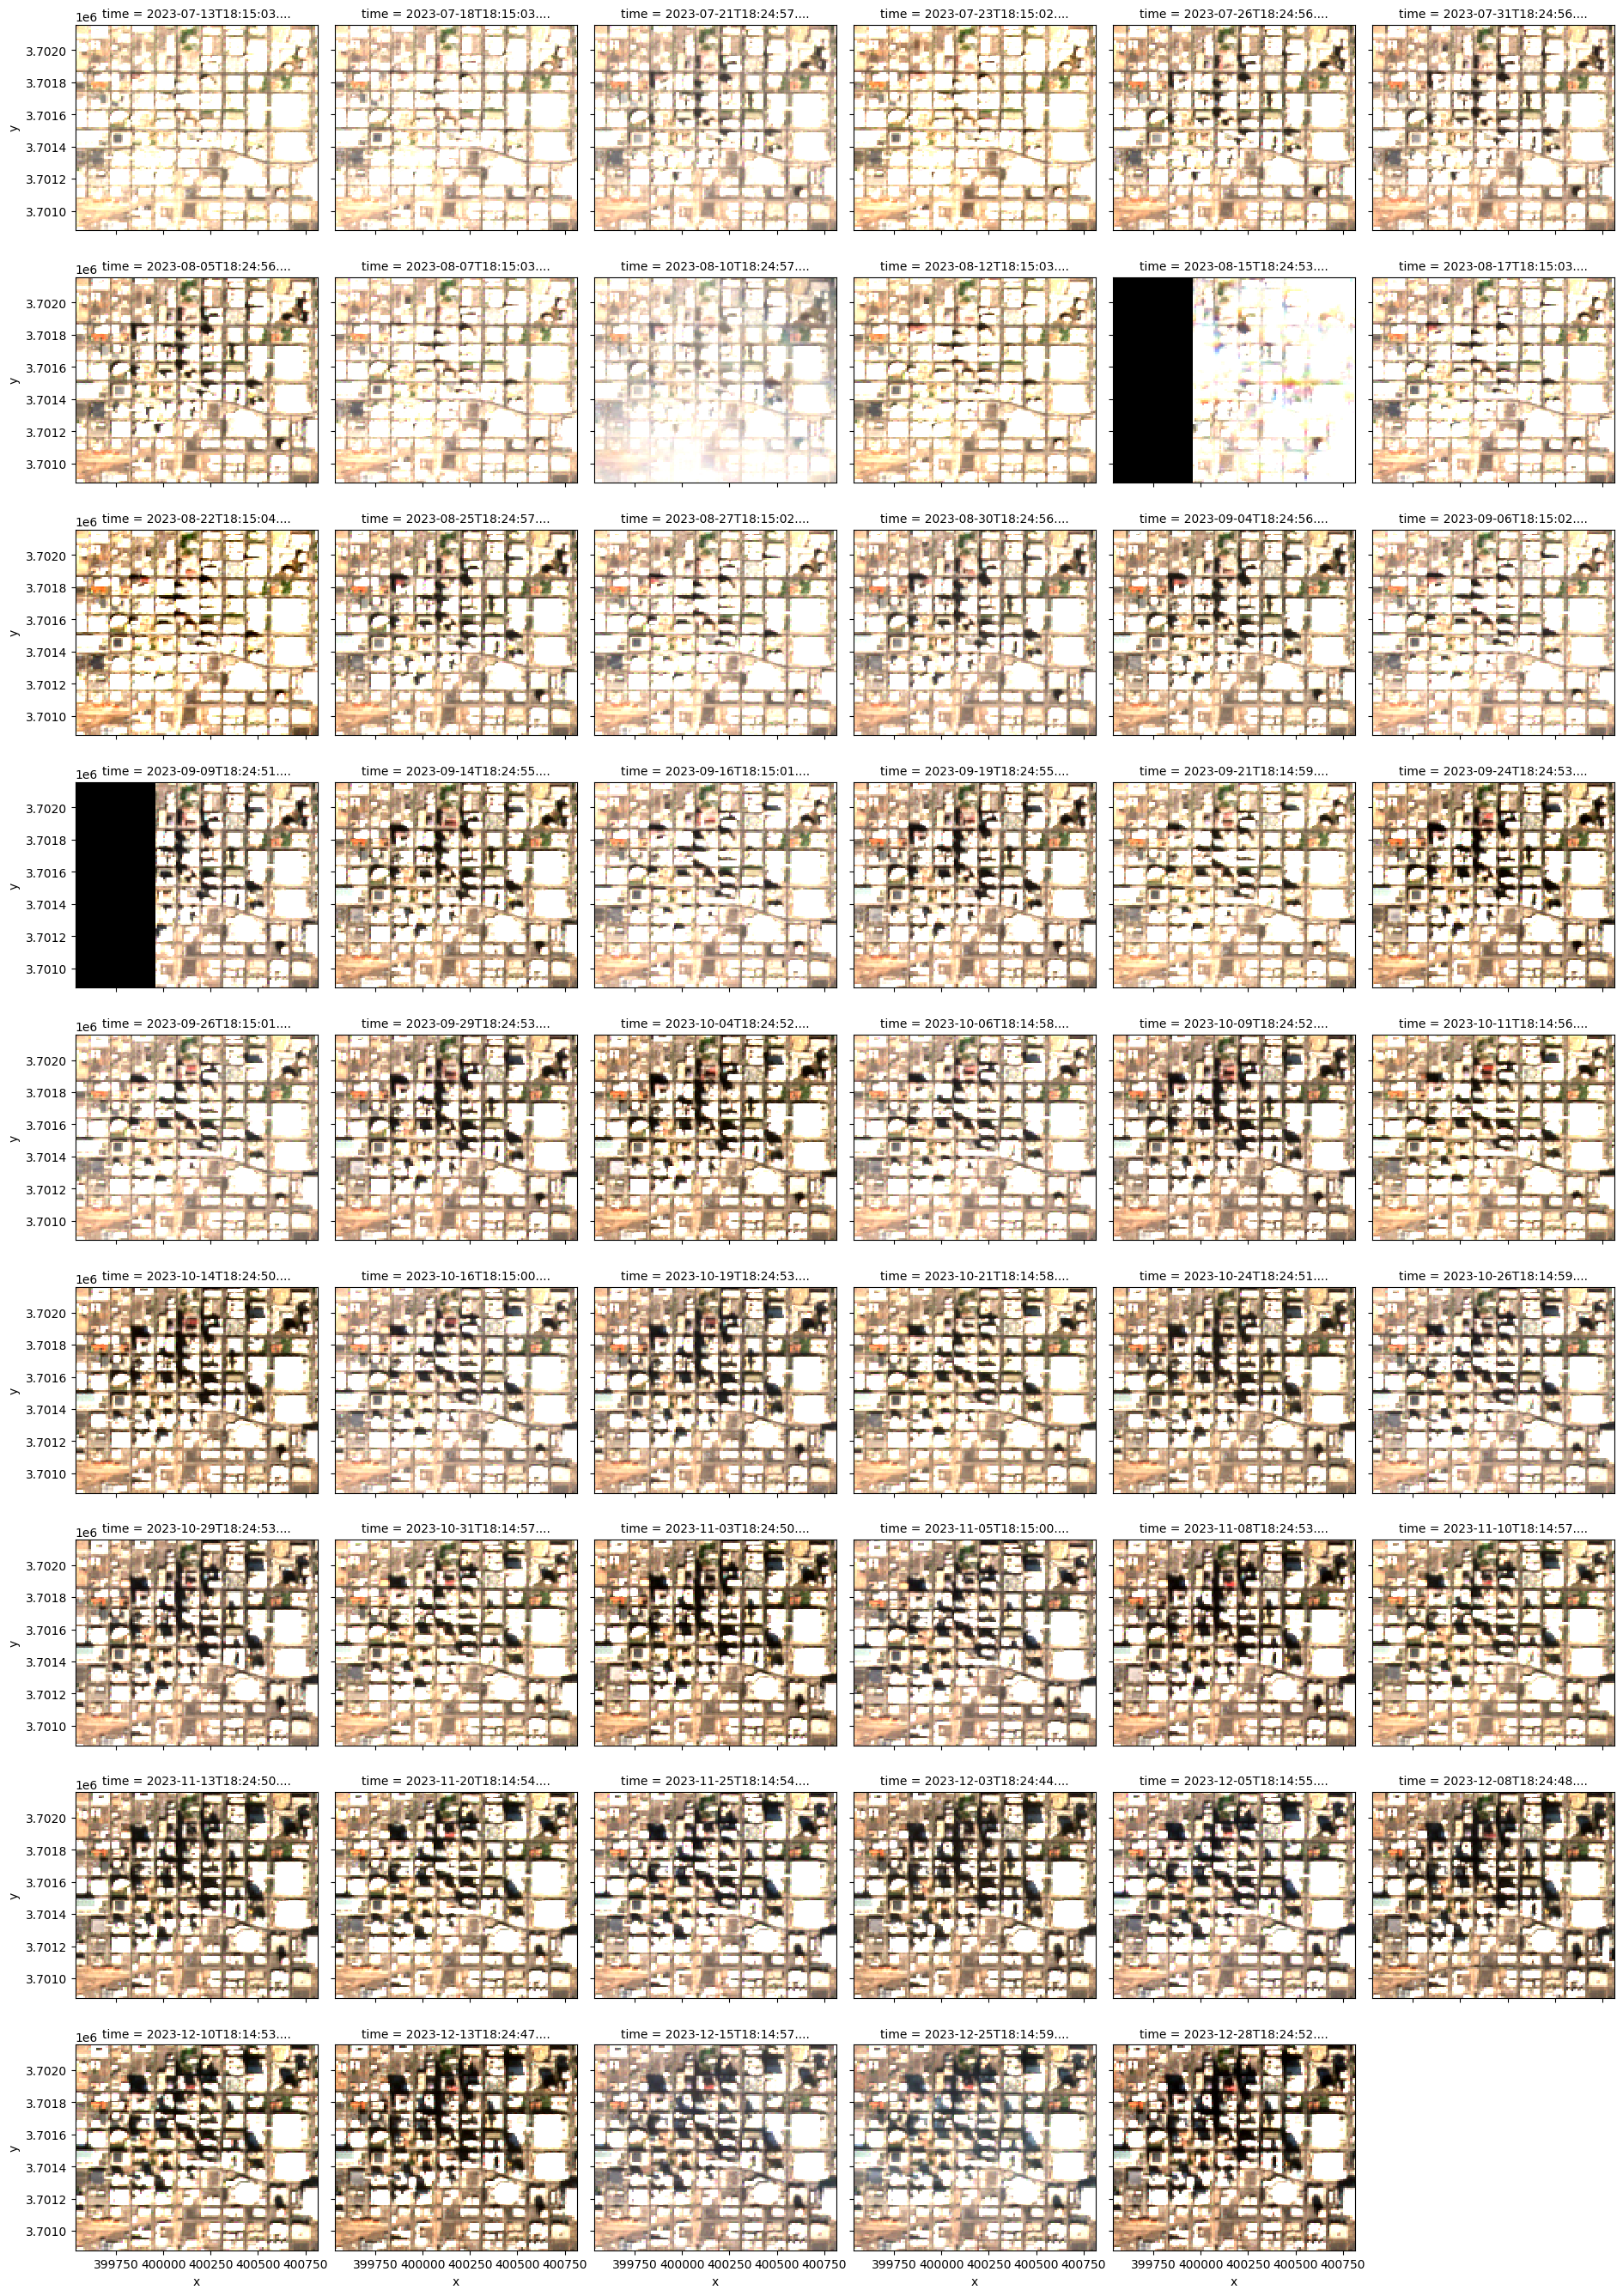

In [70]:
stack.sel(band=["red", "green", "blue"]).plot.imshow(
    row="time", rgb="band", vmin=0, vmax=2000, col_wrap=6
)

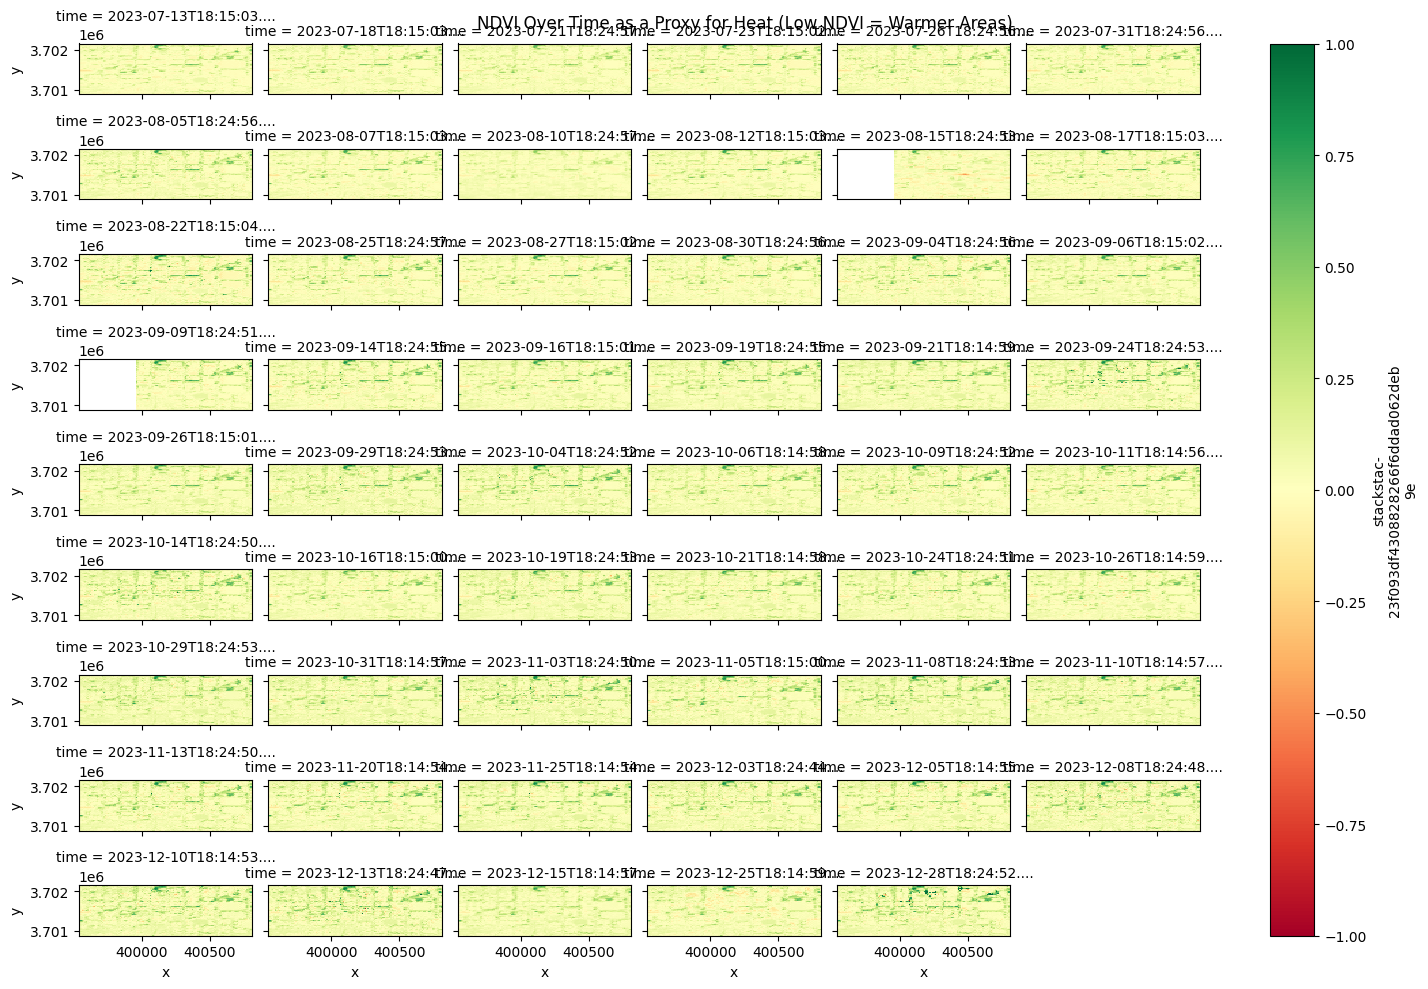

In [71]:
# Calculate NDVI
ndvi = (stack.sel(band="nir") - stack.sel(band="red")) / (stack.sel(band="nir") + stack.sel(band="red"))

# Plot NDVI as a proxy for heat levels over time
ndvi.plot.imshow(
    row="time",
    cmap="RdYlGn",  # Red-Yellow-Green colormap where red indicates low NDVI (hotter) and green indicates high NDVI (cooler)
    vmin=-1,
    vmax=1,
    col_wrap=6,
    figsize=(15, 10)
)
plt.suptitle("NDVI Over Time as a Proxy for Heat (Low NDVI = Warmer Areas)")
plt.show()
